### Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import time
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
### multiple testing
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests


import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

### Data import

#### DrugBank

In [2]:
# import xml.etree.ElementTree as ET

# # Load XML
# drugbank_xml = 'Data/DGIDB/drug_bank.xml'
# tree = ET.parse(drugbank_xml)
# root = tree.getroot()

# # Namespace
# ns = {'db': 'http://www.drugbank.ca'}

# Helper to clean tag names
def clean_tag(tag):
    return tag.split('}')[-1] if '}' in tag else tag

# Recursive function to print structure
def print_structure(elem, level=0):
    indent = '  ' * level
    print(f"{indent}- {clean_tag(elem.tag)}")
    for child in elem:
        print_structure(child, level + 1)

# # Get first drug
# first_drug = root.find('db:drug', ns)

# print("🌿 Structure of First Drug Entry:")
# print_structure(first_drug)
# print("\n🌳 Structure of First 3 Drug Entries:")
# drugs = root.findall('db:drug', ns)

# for i, drug in enumerate(drugs[:3]):
#     print(f"\n🔬 Drug {i+1}:")
#     print_structure(drug)


In [3]:
def structure_drug_bank_data(drug_bank_file = 'Data/DGIDB/drug_bank.xml'):
    """
    Function to structure the drug bank data from the XML file.
    :param drug_bank_file: Path to the drug bank XML file.
    :return: DataFrame containing structured drug bank data.
    """
    ### FYI the .find command only finds the first instance of a tag, 
    ### while .findall retrieves all instances of the specified tag within the current element.

    tree = ET.parse(drug_bank_file)
    root = tree.getroot()

    # DrugBank uses a specific namespace
    ns = {'db': 'http://www.drugbank.ca'}
    ### extract all drug elements
    drugs = root.findall('db:drug', ns)
    print(f"Found {len(drugs)} drugs in the DrugBank XML.")
    # Extract drug-gene interactions
    interactions = []
    # The interactions list will store dictionaries with 'drug' and 'gene' keys.
    for drug in root.findall('db:drug', ns): # root.findall('db:drug', ns): Finds all <drug> elements using the namespace.
        drug_name  = drug.find('db:name', ns).text  # drug.find('db:name', ns): Gets the drug's name.
        # print(drug_name)
        for target in drug.findall('db:targets/db:target', ns):  # drug.findall('db:targets/db:target', ns): Finds all <target> elements within <targets>.
            # print(target.tag)
            gene_description = target.find('db:name', ns)  # target.find('db:name', ns): Extracts the gene name for each target.
            poly = target.find('db:polypeptide', ns)  # target.find('db:polypeptide', ns): Extracts the polypeptide information.
            action = target.find('db:actions/db:action', ns) # target.find('db:actions/db:action', ns): Extracts the action of the drug on the target.
            if poly is not None:
                poly_name = poly.find('db:name', ns)
                gene_name = poly.find('db:gene-name', ns)
                specific_function = poly.find('db:specific-function', ns)
                interactions.append({
                    'drug': drug_name,
                    'polypeptide': poly_name.text if poly_name is not None else None,
                    'gene': gene_name.text if gene_name is not None else None,
                    'gene_description': gene_description.text if gene_description is not None else None,
                    'action': action.text if action is not None else None,
                    'specific_function': specific_function.text if specific_function is not None else None
                })
            ############# if polypeptide is not present, we still want to add the drug and gene information
            ############# this is because some drugs may not have a polypeptide associated with them
            ############# but we still want to capture the drug and gene information
            ############# this is common in the DrugBank database, where some drugs target genes directly
            ############# and do not have a polypeptide associated with them

            else:
                gene_name = None
                specific_function = None
                poly_name = None
                action = None
                gene_description = None
                resource = None
                identifier = None
  
                interactions.append({
                        'drug': drug_name,
                        'polypeptide': poly_name.text if poly_name is not None else None,
                        'gene': gene_name.text if gene_name is not None else None,
                        'gene_description': gene_description.text if gene_description is not None else None,
                        'action': action.text if action is not None else None,
                        'specific_function': specific_function.text if specific_function is not None else None
                    })
        
    # Convert to DataFrame
    # Converts the list of dictionaries into a pandas DataFrame, which is easier to analyze, filter, and export.
    df = pd.DataFrame(interactions)

    return df

In [4]:
Drug_bank = structure_drug_bank_data('Data/DGIDB/drug_bank.xml')

Found 17430 drugs in the DrugBank XML.


In [5]:
Drug_bank

,drug,polypeptide,gene,gene_description,action,specific_function
0,Lepirudin,Prothrombin,F2,Prothrombin,inhibitor,calcium ion binding
1,Cetuximab,Epidermal growth factor receptor,EGFR,Epidermal growth factor receptor,binder,actin filament binding
2,Cetuximab,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,Low affinity immunoglobulin gamma Fc region re...,binder,GPI anchor binding
3,Cetuximab,Complement C1q subcomponent subunit A,C1QA,Complement C1q subcomponent subunit A,binder,amyloid-beta binding
4,Cetuximab,Complement C1q subcomponent subunit B,C1QB,Complement C1q subcomponent subunit B,binder,None
...,...,...,...,...,...,...
23131,Benzgalantamine,Muscle nicotinic acetylcholine receptor,None,Muscle nicotinic acetylcholine receptor,allosteric modulator,extracellular ligand-gated monoatomic ion chan...
23132,Zoxazolamine,Small conductance calcium-activated potassium ...,KCNN2,Small conductance calcium-activated potassium ...,activator,alpha-actinin binding
23133,Megestrol,Progesterone receptor,PGR,Progesterone receptor,binder,ATPase binding
23134,AZACYCLONOL,Histamine H1 receptor,HRH1,Histamine H1 receptor,inhibitor,G protein-coupled serotonin receptor activity


In [6]:
### Drug bank statistics
print(f"Number of unique medications in drugbank {Drug_bank['drug'].nunique()}")
print(f"Number of unique genes available in drugBank {Drug_bank['gene'].nunique()}")
print(f"Number of interactions within drugbank {len(Drug_bank)}")

Number of unique medications in drugbank 9368
Number of unique genes available in drugBank 4186
Number of interactions within drugbank 23136


#### PPI

In [7]:
protein_interaction = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.v12.0.txt', sep= ' ')
protein_interaction_full = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.full.v12.0.txt', sep= ' ')
protein_interaction_detailed = pd.read_csv('Data/Protein-protein interaction data/9606.protein.links.detailed.v12.0.txt', sep= ' ')
### convert proteins to their true names
protein_info = pd.read_csv('Data/Protein-protein interaction data/9606.protein.info.v12.0.txt', on_bad_lines='skip', sep='\t')
protein_aliases= pd.read_csv('Data/Protein-protein interaction data/9606.protein.aliases.v12.0.txt', on_bad_lines='skip', sep='\t')

In [8]:
### convert proteins to their true names
protein_info = pd.read_csv('Data/Protein-protein interaction data/9606.protein.info.v12.0.txt', on_bad_lines='skip', sep='\t')
protein_aliases= pd.read_csv('Data/Protein-protein interaction data/9606.protein.aliases.v12.0.txt', on_bad_lines='skip', sep='\t')

# Method 1: Using the to_dict() method with 'index' as orient
protein_info_translate_name_dict = protein_info.set_index('#string_protein_id')['preferred_name'].to_dict()
protein_alias_translate_name_dict = protein_aliases.set_index('#string_protein_id')['alias'].to_dict()
#print(protein_info_translate_name_dict)

### Protein1
protein1_name = []
for prot_id in tqdm(protein_interaction['protein1']):
    if prot_id in protein_info_translate_name_dict:
        protein1_name.append(protein_info_translate_name_dict[prot_id])
    elif prot_id in protein_alias_translate_name_dict:
        protein1_name.append(protein_alias_translate_name_dict[prot_id])
    else:
        protein1_name.append('')

### Protein 2
protein2_name = []
for prot_id in tqdm(protein_interaction['protein2']):
    if prot_id in protein_info_translate_name_dict:
        protein2_name.append(protein_info_translate_name_dict[prot_id])
    elif prot_id in protein_alias_translate_name_dict:
        protein2_name.append(protein_alias_translate_name_dict[prot_id])
    else:
        protein2_name.append('')

protein_interaction['Translated_protein_1'] = protein1_name
protein_interaction['Translated_protein_2'] = protein2_name

# Create a set of all (protein1, protein2) pairs
ppi_pairs = set(zip(protein_interaction['Translated_protein_1'], protein_interaction['Translated_protein_2']))
# Check for missing reverse pairs
missing_reverse = []
for a, b in ppi_pairs:
    if (b, a) not in ppi_pairs:
        missing_reverse.append((a, b))

print(f"Number of pairs missing their reverse: {len(missing_reverse)}")
if missing_reverse:
    print("Examples:", missing_reverse[:10])
else:
    print("All pairs have their reverse present.")

100%|██████████| 13715404/13715404 [00:02<00:00, 5433514.48it/s]


Number of pairs missing their reverse: 0
All pairs have their reverse present.


In [9]:
protein_interaction

,protein1,protein2,combined_score,Translated_protein_1,Translated_protein_2
0,9606.ENSP00000000233,9606.ENSP00000356607,173,ARF5,RALGPS2
1,9606.ENSP00000000233,9606.ENSP00000427567,154,ARF5,FHDC1
2,9606.ENSP00000000233,9606.ENSP00000253413,151,ARF5,ATP6V1E1
3,9606.ENSP00000000233,9606.ENSP00000493357,471,ARF5,CYTH2
4,9606.ENSP00000000233,9606.ENSP00000324127,201,ARF5,PSD3
...,...,...,...,...,...
13715399,9606.ENSP00000501317,9606.ENSP00000475489,195,RFX7,MPHOSPH9
13715400,9606.ENSP00000501317,9606.ENSP00000370447,158,RFX7,VCX
13715401,9606.ENSP00000501317,9606.ENSP00000312272,226,RFX7,YPEL2
13715402,9606.ENSP00000501317,9606.ENSP00000402092,169,RFX7,SAMD3


#### SOM

In [10]:
### Somatic mutation data
somatic_mutation = pd.read_csv('Data/TCGA/SOM/cohortMAF.2025-11-12.maf', sep= '\t')
somatic_mutation['Case ID'] = somatic_mutation['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('-').tolist()

In [11]:
### Pull procedures through ICD translation
def query_UMLS(query, codingSystem):
    query = str.upper(query)
    codingSystem = str.upper(codingSystem)
    base_url = 'https://uts-ws.nlm.nih.gov/rest'
    apikey = '6ff64660-bd02-43d6-8b7e-506cbba7242e'
    endpoint = f'content/current/source/{codingSystem}/{query}?'
    apiQuery = f'{base_url}/{endpoint}apiKey={apikey}'
    #print(apiQuery)
    resp = requests.get(apiQuery)
    return resp.json()['result']['name']                                                                                                                         

codingSystems = ['CPT', 'HCPT', 'HCPCS', 'OT', 'ICD9CM', 'ICD10CM']

def translateICD(query):
    codingSystems = ['CPT', 'HCPT', 'HCPCS', 'OT', 'ICD9CM', 'ICD10CM']
    descript = np.nan
    for code in codingSystems:
        try:
            descript = query_UMLS(str(query), code)
            break
        except:
            continue
    return descript

### Data viewing

#### Protein protein interaction network

In [12]:
protein_interaction

,protein1,protein2,combined_score,Translated_protein_1,Translated_protein_2
0,9606.ENSP00000000233,9606.ENSP00000356607,173,ARF5,RALGPS2
1,9606.ENSP00000000233,9606.ENSP00000427567,154,ARF5,FHDC1
2,9606.ENSP00000000233,9606.ENSP00000253413,151,ARF5,ATP6V1E1
3,9606.ENSP00000000233,9606.ENSP00000493357,471,ARF5,CYTH2
4,9606.ENSP00000000233,9606.ENSP00000324127,201,ARF5,PSD3
...,...,...,...,...,...
13715399,9606.ENSP00000501317,9606.ENSP00000475489,195,RFX7,MPHOSPH9
13715400,9606.ENSP00000501317,9606.ENSP00000370447,158,RFX7,VCX
13715401,9606.ENSP00000501317,9606.ENSP00000312272,226,RFX7,YPEL2
13715402,9606.ENSP00000501317,9606.ENSP00000402092,169,RFX7,SAMD3


In [13]:
print(len(set(protein_interaction['protein1'])))
print(len(set(protein_interaction['protein2'])))

19622
19622


### Somatic mutation data

In [14]:
somatic_mutation

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,COSMIC,hotspot,tumor_bam_uuid,normal_bam_uuid,RNA_Support,RNA_depth,RNA_ref_count,RNA_alt_count,callers,Case ID
0,CASZ1,54897,BI,GRCh38,chr1,10665164,10665164,+,Missense_Mutation,SNP,...,NaN,N,6e321a79-190d-4f71-a7d3-5cb440fbc1ab,1d5d2df0-afb8-453d-9568-c18dfd6c278e,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CQ-A4C7
1,SLC30A2,7780,BI,GRCh38,chr1,26042554,26042554,+,Missense_Mutation,SNP,...,NaN,N,6e321a79-190d-4f71-a7d3-5cb440fbc1ab,1d5d2df0-afb8-453d-9568-c18dfd6c278e,Unknown,NaN,NaN,NaN,muse;mutect2,TCGA-CQ-A4C7
2,BEST4,266675,BI,GRCh38,chr1,44785270,44785270,+,Silent,SNP,...,NaN,N,6e321a79-190d-4f71-a7d3-5cb440fbc1ab,1d5d2df0-afb8-453d-9568-c18dfd6c278e,Unknown,NaN,NaN,NaN,muse;mutect2,TCGA-CQ-A4C7
3,ADGRL2,23266,BI,GRCh38,chr1,81907141,81907141,+,Silent,SNP,...,NaN,N,6e321a79-190d-4f71-a7d3-5cb440fbc1ab,1d5d2df0-afb8-453d-9568-c18dfd6c278e,Unknown,NaN,NaN,NaN,muse;mutect2,TCGA-CQ-A4C7
4,RPL5,6125,BI,GRCh38,chr1,92836219,92836219,+,Silent,SNP,...,NaN,N,6e321a79-190d-4f71-a7d3-5cb440fbc1ab,1d5d2df0-afb8-453d-9568-c18dfd6c278e,Unknown,NaN,NaN,NaN,muse;mutect2,TCGA-CQ-A4C7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82349,ZNF30,90075,BI,GRCh38,chr19,34944344,34944344,+,Nonsense_Mutation,SNP,...,NaN,N,c992c2fa-2cf4-46b8-92e8-82880a83ccda,585a4c4e-8e83-4e3d-8662-daeaeeccbd5e,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CQ-6222
82350,PIH1D1,55011,BI,GRCh38,chr19,49446603,49446603,+,Missense_Mutation,SNP,...,COSM4754899,N,c992c2fa-2cf4-46b8-92e8-82880a83ccda,585a4c4e-8e83-4e3d-8662-daeaeeccbd5e,Unknown,NaN,NaN,NaN,muse;mutect2,TCGA-CQ-6222
82351,NRIP1,8204,BI,GRCh38,chr21,14967159,14967159,+,Missense_Mutation,SNP,...,NaN,N,c992c2fa-2cf4-46b8-92e8-82880a83ccda,585a4c4e-8e83-4e3d-8662-daeaeeccbd5e,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CQ-6222
82352,INPP5J,27124,BI,GRCh38,chr22,31126429,31126429,+,Missense_Mutation,SNP,...,NaN,N,c992c2fa-2cf4-46b8-92e8-82880a83ccda,585a4c4e-8e83-4e3d-8662-daeaeeccbd5e,Unknown,NaN,NaN,NaN,muse;mutect2,TCGA-CQ-6222


In [15]:
### identify number of unique patients in the cohort
print(len(set(somatic_mutation['Tumor_Sample_Barcode'])))
### identify number of unique genes in the cohort
print(len(set(somatic_mutation['Hugo_Symbol'])))
### identify number of unique cases in the cohort
print(len(set(somatic_mutation['Case ID'])))


470
16305
468


### CNV data

In [16]:
sample_sheet = pd.read_csv('Data/TCGA/Gene level CNV/gdc_sample_sheet.2025-11-03.tsv', sep= '\t')
manifest = pd.read_csv('Data/TCGA/Gene level CNV/gdc_manifest.2025-11-03.174310.txt', sep= '\t')

In [17]:
### get length of Gene level CNV folder
cnv_folder = 'Data/TCGA/Gene level CNV/'
cnv_files = os.listdir(cnv_folder)
print(len(cnv_files))

1552


In [18]:
manifest

,id,filename,md5,size,state
0,21f39dce-e4a6-41e0-a0ab-876539c9b890,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,fc6b1e3abd83742a1014dccb849f1a3d,3446807,released
1,5a33ddaa-89bc-4062-9a52-be54702306d7,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,f5ce00ee030b9f5e964858a2e685d454,3436904,released
2,6b93f364-b672-464d-a418-f22a673b5a8b,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,5fbd50d4fa1316bf630efa1831a82467,3445499,released
3,4e464403-f3aa-4c3b-9b9b-885163810b60,TCGA-HNSC.a2d2b82f-f217-4aed-97da-c6ba3f5ce4dc...,fd54a22b16092579ee791909f178bff5,3446862,released
4,827b6345-4838-4d54-bb8a-db0cc38f5b9b,TCGA-HNSC.a2d2b82f-f217-4aed-97da-c6ba3f5ce4dc...,ebefa860e7c2a6942379dd9c6e3c6d7f,3445506,released
...,...,...,...,...,...
1543,659840dd-4d86-45d6-822b-8919ce76925c,TCGA-HNSC.ebd9488f-5ae7-49c7-813d-308b00ec5f05...,1b17a6e69312254b521ea5fb7ab69c37,3437237,released
1544,a39819a5-1482-4911-be8f-c21619dc8346,TCGA-HNSC.58c963a0-937b-4e29-9d36-7bcf83d12fea...,6e88feab88c8718117019507b50ee7fe,3433403,released
1545,e0ed5b1f-a478-47d4-8b31-2000c3ed3e11,TCGA-HNSC.8383139c-78ce-4fec-ace5-479cb3ca3c8e...,656ab0f579f411838d7961f526fd9e17,3430658,released
1546,251227bb-45e1-43a7-9166-698c31e225a7,TCGA-HNSC.ca39edab-2932-4e62-9d5c-4588dff4c2ee...,5406f2e4563b3d584c02c9a082c34b18,3431366,released


In [19]:
sample_sheet

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Tissue Type,Tumor Descriptor,Specimen Type,Preservation Method
0,21f39dce-e4a6-41e0-a0ab-876539c9b890,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,"TCGA-CQ-A4C7, TCGA-CQ-A4C7","TCGA-CQ-A4C7-10A, TCGA-CQ-A4C7-01A","Normal, Tumor","Not Applicable, Primary","Peripheral Blood NOS, Solid Tissue","Unknown, Unknown"
1,5a33ddaa-89bc-4062-9a52-be54702306d7,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CQ-A4C7,TCGA-CQ-A4C7-01A,Tumor,Primary,Solid Tissue,Unknown
2,6b93f364-b672-464d-a418-f22a673b5a8b,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,"TCGA-CQ-A4C7, TCGA-CQ-A4C7","TCGA-CQ-A4C7-10A, TCGA-CQ-A4C7-01A","Normal, Tumor","Not Applicable, Primary","Peripheral Blood NOS, Solid Tissue","Unknown, Unknown"
3,4e464403-f3aa-4c3b-9b9b-885163810b60,TCGA-HNSC.a2d2b82f-f217-4aed-97da-c6ba3f5ce4dc...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,"TCGA-BA-4077, TCGA-BA-4077","TCGA-BA-4077-01B, TCGA-BA-4077-10A","Tumor, Normal","Primary, Not Applicable","Unknown, Peripheral Blood NOS","Unknown, Unknown"
4,827b6345-4838-4d54-bb8a-db0cc38f5b9b,TCGA-HNSC.a2d2b82f-f217-4aed-97da-c6ba3f5ce4dc...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,"TCGA-BA-4077, TCGA-BA-4077","TCGA-BA-4077-01B, TCGA-BA-4077-10A","Tumor, Normal","Primary, Not Applicable","Unknown, Peripheral Blood NOS","Unknown, Unknown"
...,...,...,...,...,...,...,...,...,...,...,...
1543,659840dd-4d86-45d6-822b-8919ce76925c,TCGA-HNSC.ebd9488f-5ae7-49c7-813d-308b00ec5f05...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-C9-A480,TCGA-C9-A480-01A,Tumor,Primary,Solid Tissue,OCT
1544,a39819a5-1482-4911-be8f-c21619dc8346,TCGA-HNSC.58c963a0-937b-4e29-9d36-7bcf83d12fea...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CR-6470,TCGA-CR-6470-01A,Tumor,Primary,Solid Tissue,Unknown
1545,e0ed5b1f-a478-47d4-8b31-2000c3ed3e11,TCGA-HNSC.8383139c-78ce-4fec-ace5-479cb3ca3c8e...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CQ-6228,TCGA-CQ-6228-01A,Tumor,Primary,Solid Tissue,Unknown
1546,251227bb-45e1-43a7-9166-698c31e225a7,TCGA-HNSC.ca39edab-2932-4e62-9d5c-4588dff4c2ee...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CV-6941,TCGA-CV-6941-01A,Tumor,Primary,Solid Tissue,Unknown


In [20]:
len(set(sample_sheet['File Name']))

1548

In [21]:
len(set(sample_sheet['File ID']))

1548

In [22]:
### split case id values by comma and and to list
case_ids = []
ids = sample_sheet['Case ID'].unique()
for cases in ids:
    if ',' in cases:
        cases = cases.split(',')
        for case2 in cases:
            case_ids.append(case2.strip())
    else:
        case_ids.append(cases)
    # print(case_ids)
print(len(set(case_ids)))

517


In [23]:
case_ids =len(set(case_ids))
print(case_ids)

517


In [24]:
manifest

,id,filename,md5,size,state
0,21f39dce-e4a6-41e0-a0ab-876539c9b890,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,fc6b1e3abd83742a1014dccb849f1a3d,3446807,released
1,5a33ddaa-89bc-4062-9a52-be54702306d7,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,f5ce00ee030b9f5e964858a2e685d454,3436904,released
2,6b93f364-b672-464d-a418-f22a673b5a8b,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,5fbd50d4fa1316bf630efa1831a82467,3445499,released
3,4e464403-f3aa-4c3b-9b9b-885163810b60,TCGA-HNSC.a2d2b82f-f217-4aed-97da-c6ba3f5ce4dc...,fd54a22b16092579ee791909f178bff5,3446862,released
4,827b6345-4838-4d54-bb8a-db0cc38f5b9b,TCGA-HNSC.a2d2b82f-f217-4aed-97da-c6ba3f5ce4dc...,ebefa860e7c2a6942379dd9c6e3c6d7f,3445506,released
...,...,...,...,...,...
1543,659840dd-4d86-45d6-822b-8919ce76925c,TCGA-HNSC.ebd9488f-5ae7-49c7-813d-308b00ec5f05...,1b17a6e69312254b521ea5fb7ab69c37,3437237,released
1544,a39819a5-1482-4911-be8f-c21619dc8346,TCGA-HNSC.58c963a0-937b-4e29-9d36-7bcf83d12fea...,6e88feab88c8718117019507b50ee7fe,3433403,released
1545,e0ed5b1f-a478-47d4-8b31-2000c3ed3e11,TCGA-HNSC.8383139c-78ce-4fec-ace5-479cb3ca3c8e...,656ab0f579f411838d7961f526fd9e17,3430658,released
1546,251227bb-45e1-43a7-9166-698c31e225a7,TCGA-HNSC.ca39edab-2932-4e62-9d5c-4588dff4c2ee...,5406f2e4563b3d584c02c9a082c34b18,3431366,released


### Clinical data

In [27]:
clinical_data = pd.read_csv('Data/TCGA/Gene level CNV/clinical.tsv', sep= '\t')

In [28]:
for col in clinical_data.columns:
    print(col)

project.project_id
cases.case_id
cases.consent_type
cases.days_to_consent
cases.days_to_lost_to_followup
cases.disease_type
cases.index_date
cases.lost_to_followup
cases.primary_site
cases.submitter_id
demographic.age_at_index
demographic.age_is_obfuscated
demographic.cause_of_death
demographic.cause_of_death_source
demographic.country_of_birth
demographic.country_of_residence_at_enrollment
demographic.days_to_birth
demographic.days_to_death
demographic.demographic_id
demographic.education_level
demographic.ethnicity
demographic.gender
demographic.marital_status
demographic.occupation_duration_years
demographic.population_group
demographic.premature_at_birth
demographic.race
demographic.submitter_id
demographic.vital_status
demographic.weeks_gestation_at_birth
demographic.year_of_birth
demographic.year_of_death
diagnoses.adrenal_hormone
diagnoses.age_at_diagnosis
diagnoses.ajcc_clinical_m
diagnoses.ajcc_clinical_n
diagnoses.ajcc_clinical_stage
diagnoses.ajcc_clinical_t
diagnoses.ajcc_p

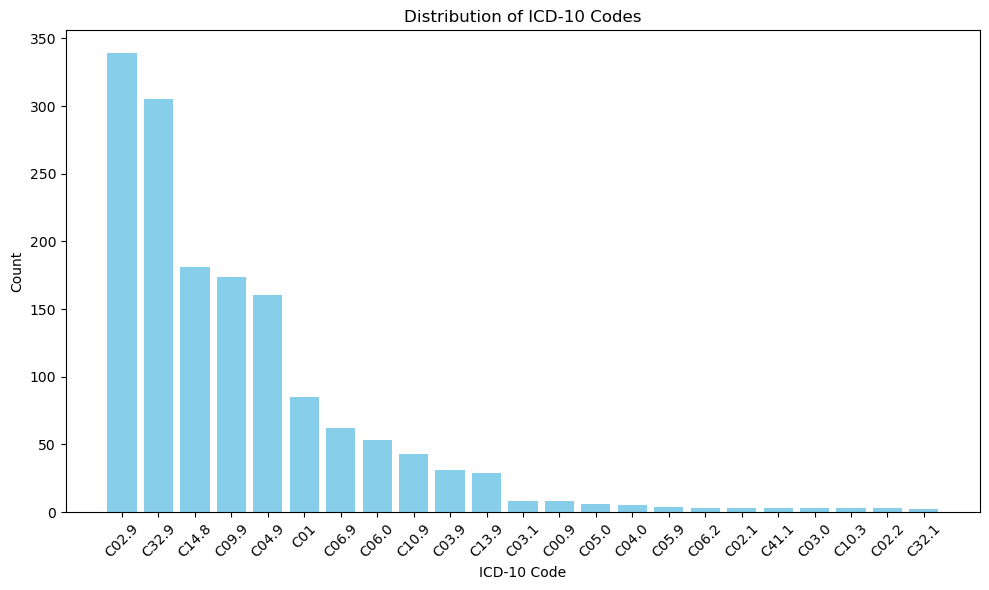

In [29]:
icd_10 = clinical_data['diagnoses.icd_10_code']
icd_10_value_counts = icd_10.value_counts().reset_index()
icd_10_value_counts.columns = ['ICD-10 Code', 'Count']
###drop the '--' code
icd_10_value_counts = icd_10_value_counts[icd_10_value_counts['ICD-10 Code'] != "'--"]
icd_10_value_counts = icd_10_value_counts[icd_10_value_counts['ICD-10 Code'] != '']
### plot icd_10 code
plt.figure(figsize=(10, 6))
plt.bar(icd_10_value_counts['ICD-10 Code'], icd_10_value_counts['Count'], color='skyblue')
plt.xlabel('ICD-10 Code')
plt.ylabel('Count')
plt.title('Distribution of ICD-10 Codes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
### create translation dictionary for ICD-10 codes to description
icd_10_translation = {}
for code in tqdm(icd_10_value_counts['ICD-10 Code']):
    ### double check if code in dictionary already
    if code not in icd_10_translation:
        description = translateICD(code)
        icd_10_translation[code] = description

100%|██████████| 23/23 [00:23<00:00,  1.00s/it]


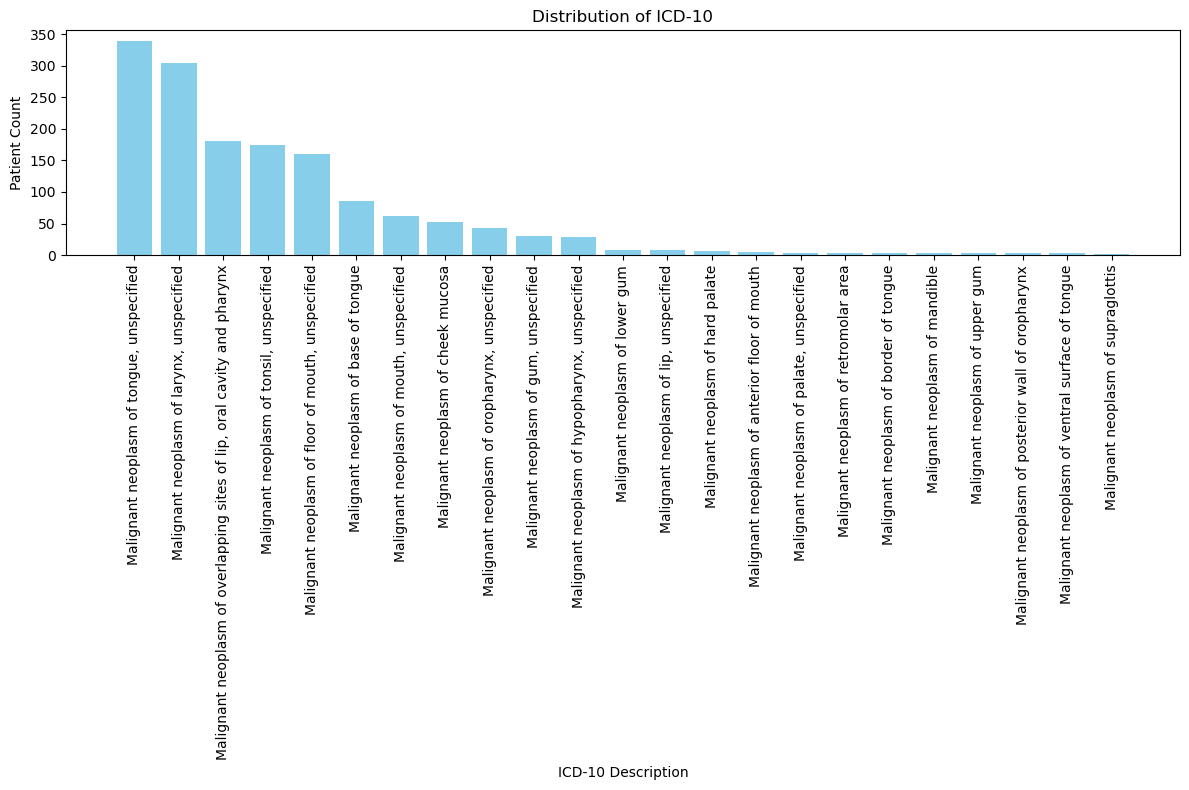

In [40]:
### redo graph with translated ICD codes
icd_10_value_counts['Description'] = icd_10_value_counts['ICD-10 Code'].map(icd_10_translation)
plt.figure(figsize=(12, 8))
plt.bar(icd_10_value_counts['Description'], icd_10_value_counts['Count'], color='skyblue')
plt.xlabel('ICD-10 Description')
plt.ylabel('Patient Count')
plt.title('Distribution of ICD-10')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [32]:
### table of ICD-10 codes with descriptions, and counts
icd_10_value_counts[['ICD-10 Code', 'Description', 'Count']]

,ICD-10 Code,Description,Count
1,C02.9,"Malignant neoplasm of tongue, unspecified",339
2,C32.9,"Malignant neoplasm of larynx, unspecified",305
3,C14.8,Malignant neoplasm of overlapping sites of lip...,181
4,C09.9,"Malignant neoplasm of tonsil, unspecified",174
5,C04.9,"Malignant neoplasm of floor of mouth, unspecified",160
6,C01,Malignant neoplasm of base of tongue,85
7,C06.9,"Malignant neoplasm of mouth, unspecified",62
8,C06.0,Malignant neoplasm of cheek mucosa,53
9,C10.9,"Malignant neoplasm of oropharynx, unspecified",43
10,C03.9,"Malignant neoplasm of gum, unspecified",31


In [33]:
clinical_data

,project.project_id,cases.case_id,cases.consent_type,cases.days_to_consent,cases.days_to_lost_to_followup,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,...,treatments.treatment_duration,treatments.treatment_effect,treatments.treatment_effect_indicator,treatments.treatment_frequency,treatments.treatment_id,treatments.treatment_intent_type,treatments.treatment_or_therapy,treatments.treatment_outcome,treatments.treatment_outcome_duration,treatments.treatment_type
0,TCGA-HNSC,01420c4e-6013-4d3f-87bd-a6cd9e3f8e87,Informed Consent,78,'--,Squamous Cell Neoplasms,Diagnosis,No,"Other and ill-defined sites in lip, oral cavit...",TCGA-BA-5152,...,'--,'--,'--,'--,50b7bb08-be60-4db3-849c-04887ae8befd,Adjuvant,no,'--,'--,"Pharmaceutical Therapy, NOS"
1,TCGA-HNSC,01420c4e-6013-4d3f-87bd-a6cd9e3f8e87,Informed Consent,78,'--,Squamous Cell Neoplasms,Diagnosis,No,"Other and ill-defined sites in lip, oral cavit...",TCGA-BA-5152,...,'--,'--,'--,'--,60ecf5eb-e9bb-5db9-bf8f-06f58807e43e,Adjuvant,yes,'--,'--,"Radiation, External Beam"
2,TCGA-HNSC,02dcc11f-4f0e-4c9e-8d96-d22d47beef5d,Informed Consent,786,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CQ-5329,...,'--,'--,'--,'--,0f2552a5-d332-4632-821a-ed967115761c,Adjuvant,no,'--,'--,"Radiation Therapy, NOS"
3,TCGA-HNSC,02dcc11f-4f0e-4c9e-8d96-d22d47beef5d,Informed Consent,786,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CQ-5329,...,'--,'--,'--,'--,3f6fbd91-2e65-5a29-8cc8-6a8a91ac344e,Adjuvant,no,'--,'--,"Pharmaceutical Therapy, NOS"
4,TCGA-HNSC,02dcc11f-4f0e-4c9e-8d96-d22d47beef5d,Informed Consent,786,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CQ-5329,...,'--,'--,'--,'--,4b506642-d2c6-4c7a-a75b-c2f1766ebd51,Cure,yes,No Measurable Disease,'--,"Surgery, NOS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,TCGA-HNSC,ff9db03d-f81c-4079-8b05-f5a8c05b8cfe,Consent by Death,'--,'--,Squamous Cell Neoplasms,Diagnosis,No,"Other and ill-defined sites in lip, oral cavit...",TCGA-CV-6938,...,'--,'--,'--,'--,f2896210-2974-4f2a-a311-4630ed915158,Adjuvant,unknown,'--,'--,"Radiation Therapy, NOS"
2158,TCGA-HNSC,ffcf851d-7fa1-4b45-911a-a3fbd74c253a,Informed Consent,13,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CN-6016,...,'--,'--,'--,'--,45fab7ce-360c-430c-ac12-9b67ff8def8c,Cure,yes,No Measurable Disease,'--,Not Reported
2159,TCGA-HNSC,ffcf851d-7fa1-4b45-911a-a3fbd74c253a,Informed Consent,13,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CN-6016,...,'--,'--,'--,'--,5a90fc9f-9371-5a71-ac26-3a6c24daf524,Adjuvant,yes,'--,'--,"Radiation, External Beam"
2160,TCGA-HNSC,ffcf851d-7fa1-4b45-911a-a3fbd74c253a,Informed Consent,13,'--,Squamous Cell Neoplasms,Diagnosis,No,Other and unspecified parts of tongue,TCGA-CN-6016,...,'--,'--,'--,'--,8285476e-b013-4f1d-9072-22cc847dce3b,Adjuvant,yes,'--,'--,Chemotherapy


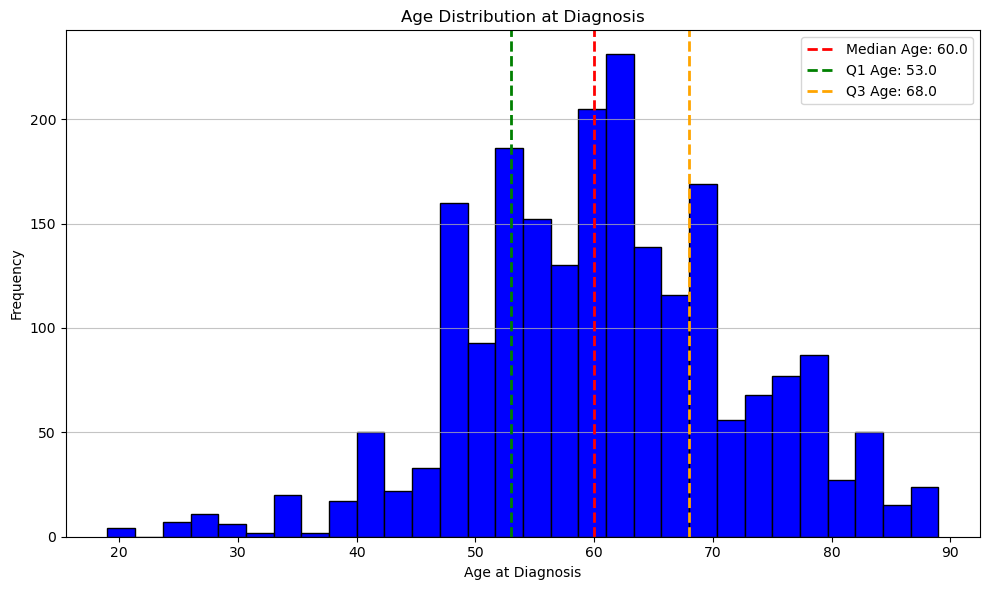

In [39]:
### age distribution
ages = clinical_data['demographic.age_at_index']
ages = ages.dropna()
ages = ages[ages != "'--"]
ages = ages.astype(int)
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=30, color='blue', edgecolor='black')
plt.xlabel('Age at Diagnosis')
plt.ylabel('Frequency')
plt.title('Age Distribution at Diagnosis')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
# ### add vertical bars for wehre the majority of ages lie, line for showing q1 and q3
plt.axvline(ages.median(), color='red', linestyle='--', linewidth=2, label=f'Median Age: {ages.median()}')
plt.axvline(ages.quantile(0.25), color='green', linestyle='--', linewidth=2, label=f'Q1 Age: {ages.quantile(0.25)}')
plt.axvline(ages.quantile(0.75), color='orange', linestyle='--', linewidth=2, label=f'Q3 Age: {ages.quantile(0.75)}')
plt.legend()
plt.show()


In [35]:
len(clinical_data)

2162

In [36]:
clinical_data = pd.read_csv('Data/TCGA/Gene level CNV/clinical.tsv', sep= '\t')

In [37]:
for col in clinical_data.columns:
    print(col)

project.project_id
cases.case_id
cases.consent_type
cases.days_to_consent
cases.days_to_lost_to_followup
cases.disease_type
cases.index_date
cases.lost_to_followup
cases.primary_site
cases.submitter_id
demographic.age_at_index
demographic.age_is_obfuscated
demographic.cause_of_death
demographic.cause_of_death_source
demographic.country_of_birth
demographic.country_of_residence_at_enrollment
demographic.days_to_birth
demographic.days_to_death
demographic.demographic_id
demographic.education_level
demographic.ethnicity
demographic.gender
demographic.marital_status
demographic.occupation_duration_years
demographic.population_group
demographic.premature_at_birth
demographic.race
demographic.submitter_id
demographic.vital_status
demographic.weeks_gestation_at_birth
demographic.year_of_birth
demographic.year_of_death
diagnoses.adrenal_hormone
diagnoses.age_at_diagnosis
diagnoses.ajcc_clinical_m
diagnoses.ajcc_clinical_n
diagnoses.ajcc_clinical_stage
diagnoses.ajcc_clinical_t
diagnoses.ajcc_p

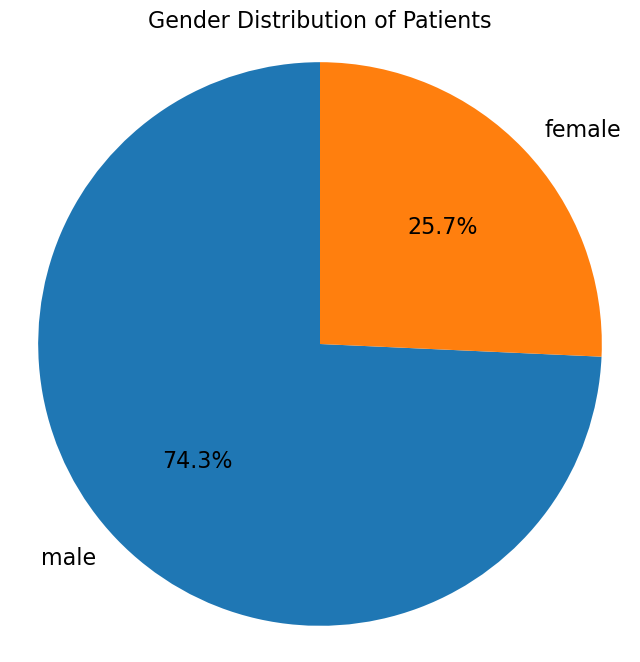

In [38]:
### plot gender distribution in pie chart
genders = clinical_data['demographic.gender']
gender_counts = pd.Series(genders).value_counts()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
### increase font size of title
plt.title('Gender Distribution of Patients', fontsize=16)
### increase font size of data labels
plt.setp(plt.gca().texts, fontsize=16)
plt.axis('equal')
plt.show()